In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
from sklearn.model_selection import train_test_split
import sklearn.datasets as datasets
from sklearn import metrics
import math
import tensorflow as tf

In [2]:
np.random.seed(101)

In [3]:
data = datasets.fetch_california_housing()
df = pd.DataFrame(data.data, columns=data.feature_names)
df['Target'] = pd.Series(data.target)
df.head()

,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude,Target
0,8.3252,41.0,6.984127,1.023810,322.0,2.555556,37.88,-122.23,4.526
1,8.3014,21.0,6.238137,0.971880,2401.0,2.109842,37.86,-122.22,3.585
2,7.2574,52.0,8.288136,1.073446,496.0,2.802260,37.85,-122.24,3.521
3,5.6431,52.0,5.817352,1.073059,558.0,2.547945,37.85,-122.25,3.413
4,3.8462,52.0,6.281853,1.081081,565.0,2.181467,37.85,-122.25,3.422


## Explore the data

In [4]:
df.describe()

,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude,Target
count,20640.000000,20640.000000,20640.000000,20640.000000,20640.000000,20640.000000,20640.000000,20640.000000,20640.000000
mean,3.870671,28.639486,5.429000,1.096675,1425.476744,3.070655,35.631861,-119.569704,2.068558
std,1.899822,12.585558,2.474173,0.473911,1132.462122,10.386050,2.135952,2.003532,1.153956
min,0.499900,1.000000,0.846154,0.333333,3.000000,0.692308,32.540000,-124.350000,0.149990
25%,2.563400,18.000000,4.440716,1.006079,787.000000,2.429741,33.930000,-121.800000,1.196000
50%,3.534800,29.000000,5.229129,1.048780,1166.000000,2.818116,34.260000,-118.490000,1.797000
75%,4.743250,37.000000,6.052381,1.099526,1725.000000,3.282261,37.710000,-118.010000,2.647250
max,15.000100,52.000000,141.909091,34.066667,35682.000000,1243.333333,41.950000,-114.310000,5.000010


#### Select a few features

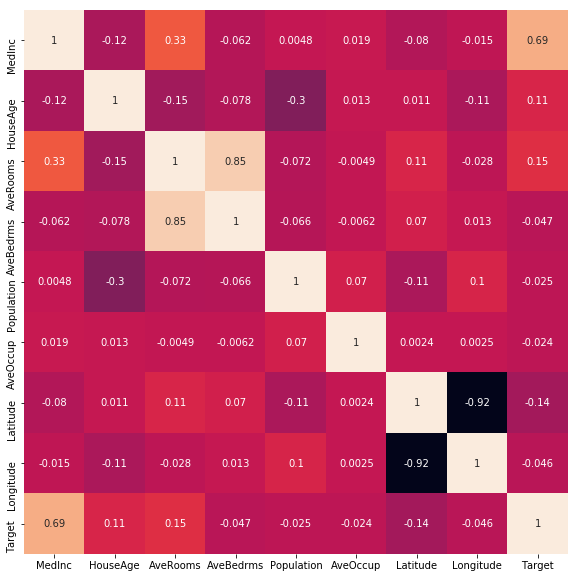

In [5]:
plt.figure(figsize=(20, 10))
sns.heatmap(df.corr(), square=True, annot=True, cbar=False)

In [6]:
# Let's ignore AveBedrms, Population, AveOccup, Longitude
feature_columns = ['MedInc', 'HouseAge', 'AveRooms', 'AveOccup', 'Latitude']

##### HouseAge looks good, no outliers

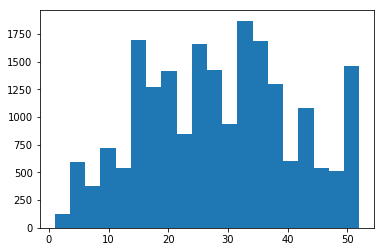

In [7]:
x = plt.hist(df['HouseAge'], bins=20)

##### AveRooms has outliers

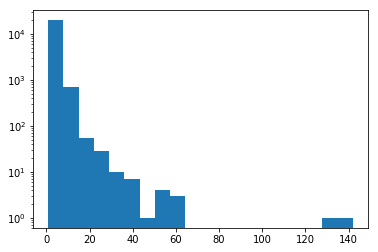

In [8]:
x = plt.hist(df['AveRooms'], bins=20)
plt.gca().set_yscale("log")

##### Clip AveRooms by 60

In [9]:
df['AveRooms'].where(df['AveRooms'] < 60, 60, inplace=True)

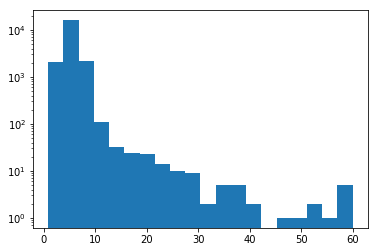

In [10]:
x = plt.hist(df['AveRooms'], bins=20)
plt.gca().set_yscale("log")

##### Let's bin Latitude

In [11]:
def get_quantiles(feature_name):
    num_buckets = 10
    boundaries = np.arange(1.0, num_buckets) / num_buckets
    quantiles = df[feature_name].quantile(boundaries)
    return [quantiles[q] for q in quantiles.keys()]

#### Split data/test/eval

In [12]:
X_train, X_eval, y_train, y_eval = train_test_split(df[feature_columns], df['Target'], test_size=0.3, random_state=46)

## Tensorflow API 
#### Synthetic Features (TBD)

In [13]:
MedInc = tf.feature_column.numeric_column('MedInc')
HouseAge = tf.feature_column.numeric_column('HouseAge')
AveRooms = tf.feature_column.numeric_column('AveRooms')
AveOccup = tf.feature_column.numeric_column('AveOccup')

Latitude = tf.feature_column.numeric_column('Latitude')
Latitude = tf.feature_column.bucketized_column(Latitude, boundaries=get_quantiles('Latitude'))

tf_feature_columns = [MedInc,HouseAge,AveRooms,AveOccup,Latitude]

#### Hyperparameters

In [42]:
learning_rate=0.01

#### The model

In [ ]:
optimizer = tf.train.FtrlOptimizer(learning_rate=learning_rate)
estimator = tf.estimator.LinearRegressor(feature_columns=tf_feature_columns, optimizer=optimizer)   

#### Loop to see how Loss and MSE converge. Use cross sampling of small batches, and calc RMSE

In [44]:
n_rounds=20
n_steps=1
batch_size=12

In [ ]:
train_metrics = []
eval_metrics = []
train_rmse = []
eval_rmse = []

for i in range(0, n_rounds):
    train_idx = np.random.choice(len(X_train), replace=False, size=batch_size)
    eval_idx = np.random.choice(len(X_eval), replace=False, size=batch_size)
    
    # Samples
    X_train_sample = X_train.iloc[train_idx]
    y_train_sample = y_train.iloc[train_idx]

    X_eval_sample = X_eval.iloc[eval_idx]
    y_eval_sample = y_eval.iloc[eval_idx]
    
    # Input fn
    train_input_fn = tf.estimator.inputs.pandas_input_fn(X_train_sample, y_train_sample, batch_size=batch_size, num_epochs=None, shuffle=True)
    predict_train_input_fn = tf.estimator.inputs.pandas_input_fn(X_train_sample, y_train_sample, batch_size=batch_size, num_epochs=1, shuffle=False)
    predict_eval_input_fn = tf.estimator.inputs.pandas_input_fn(X_eval_sample, y_eval_sample, batch_size=batch_size, num_epochs=1, shuffle=False)

    estimator.train(input_fn=train_input_fn, steps=1)
    
    train_metric = estimator.evaluate(predict_train_input_fn, steps=n_steps)
    train_metrics.append(train_metric['loss'])
    eval_metric = estimator.evaluate(predict_eval_input_fn, steps=n_steps)
    eval_metrics.append(eval_metric['loss'])
    print("round={} metrics train={} eval={}".format(i, train_metric, eval_metric))
    
    # predictions
    training_predictions = estimator.predict(input_fn=predict_train_input_fn)
    training_predictions = np.array([item['predictions'][0] for item in training_predictions])
    rmse = math.sqrt(metrics.mean_squared_error(training_predictions, y_train_sample))
    train_rmse.append(rmse)
        
    eval_predictions = estimator.predict(input_fn=predict_eval_input_fn)
    eval_predictions = np.array([item['predictions'][0] for item in eval_predictions])
    rmse = math.sqrt(metrics.mean_squared_error(eval_predictions, y_eval_sample))
    eval_rmse.append(rmse)


#### The Loss

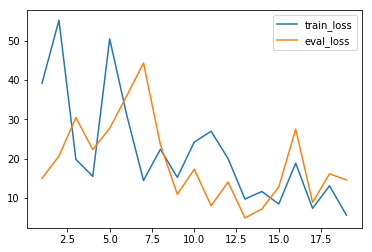

In [46]:
plt.plot(range(1,n_rounds), train_metrics[1:], label='train_loss')
plt.plot(range(1,n_rounds), eval_metrics[1:], label='eval_loss')
plt.legend()

#### The RMSE (looks like converging)

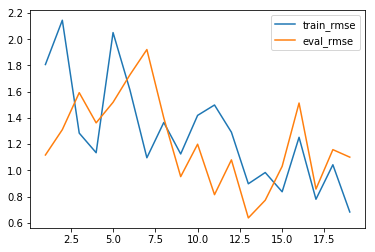

In [47]:
plt.plot(range(1,n_rounds), train_rmse[1:], label='train_rmse')
plt.plot(range(1,n_rounds), eval_rmse[1:], label='eval_rmse')
plt.legend()

#### Compare to AdamOptimizer

In [ ]:
optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate)
estimator = tf.estimator.LinearRegressor(feature_columns=tf_feature_columns, optimizer=optimizer)   

#### ...shows a weird spike

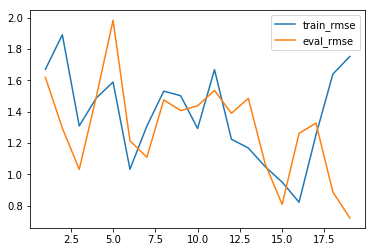

In [50]:
plt.plot(range(1,n_rounds), train_rmse[1:], label='train_rmse')
plt.plot(range(1,n_rounds), eval_rmse[1:], label='eval_rmse')
plt.legend()